In [1]:
import cv2, imageio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
def GaussianBlur(src, ksize, sigmaX, sigmaY):
    '''
    INPUT:
    src: input image
    ksize: Gaussian kernel size, tuple or integer
    sigmaX: Gaussian kernel standard deviation in X direction 
    sigmaY: Gaussian kernel standard deviation in Y direction
    
    OUTPUT:
    dst: return image 
    '''

    # 1.create Gaussian kernel
    # 1.1 create coordinates
    kx, ky = ksize
    x = np.arange(-kx//2 + 1, kx//2 + 1) # create coordinates 
    y = np.arange(-ky//2 + 1, ky//2 + 1)

    xx, yy = np.meshgrid(x, y) # create meshgrid
    """
    [[ (-1,-1) (0,-1) (1,-1) ]
     [ (-1, 0) (0, 0) (1, 0) ]
     [ (-1, 1) (0, 1) (1, 1) ]]
     """
    # 1.2 Gaussian function
    # G(x,y) = 1/(2*pi*sigmaX*sigmaY) * exp(-(x^2/(2*sigmaX^2) + y^2/(2*sigmaY^2)))
    gaussian_x = np.exp(-(xx**2)/(2*sigmaX**2)) # neglect the coefficient,because we will normalize later
    gaussian_y = np.exp(-(yy**2)/(2*sigmaY**2))
    kernel = gaussian_x * gaussian_y
    kernel = kernel / np.sum(kernel) # normalize,assert the sum of kernel is 1
    # print(kernel)
    """
    [[.075 .124  .075]
     [.124  .204 .124]
     [.075 .124  .075]]
    """
    # print(f"sum of kernel: {np.sum(kernel)}") # 1

    # 2.padding 
    # 2.1 padding size
    pad_top = ky // 2
    pad_bottom = ky // 2
    pad_left = kx // 2
    pad_right = kx // 2
    # print(f"padding size:top:{pad_top}, bottom:{pad_bottom}, left:{pad_left}, right:{pad_right}") # 1,1,1,1
    # 2.2 padding mode
    # aaa|abcde|eee -> edge
    padding_mode = 'edge'
    padded_src = np.pad(src, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode=padding_mode)
    padded_src = padded_src.astype(np.float32) # assert data type:float32
    # print(f"padding finish: {src.shape} -> {padded_src.shape}") # (height+2, width+2, channel)

    # 3.convolution
    # 3.1 initialize output image
    dst = np.zeros_like(src, dtype=np.float32) # (height, width, channel)
    # 3.2 create input size
    img_height, img_width, num_channels = src.shape
    # 3.3 convolution operation
    for i in range(img_height):
        for j in range(img_width):
            current = padded_src[i:i+ky, j:j+kx, :] # (ky, kx, channel)
            for c in range(num_channels): # R,G,B
                dst[i, j, c] = np.sum(current[:, :, c] * kernel) 
    # 3.4 clip to [0,255] and set type to uint8
    dst = np.clip(dst, 0, 255)
    dst = dst.astype(np.uint8)
    return dst
    

def medianBlur(src, ksize):
    '''
    INPUT:
    src: input image
    ksize: kernel size, tuple or intger
    
    OUTPUT:
    dst: return image 
    '''

    # padding
    pad_top = ksize // 2
    pad_bottom = ksize // 2
    pad_left = ksize // 2
    pad_right = ksize // 2

    padding_mode = 'edge'
    padded_src = np.pad(src, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode=padding_mode)

    # convolution
    dst = np.zeros_like(src, dtype=np.float32) # (height, width, channel)
    img_height, img_width, num_channels = src.shape
    for i in range(img_height):
        for j in range(img_width):
            current = padded_src[i:i+ksize, j:j+ksize, :] # (ky, kx, channel)
            for c in range(num_channels): # R,G,B
                dst[i, j, c] = np.median(current[:, :, c]) # median to select the center value
    dst = np.clip(dst, 0, 255)
    dst = dst.astype(np.uint8)
    return dst

def bilateralFilter(src, d, sigmaColor, sigmaSpace):
    '''
    INPUT:
    src: input image
    d: 	Diameter of each pixel neighborhood that is used during filtering. 
    sigmaColor: Filter sigma in the color space
    sigmaSpace: Filter sigma in the coordinate space.
    
    OUTPUT:
    dst: return image 
    '''
    src = src.astype(np.float32)
    # 1.create Spatial kernel
    # 1.1 create coordinates
    x = np.arange(-d//2 + 1, d//2 + 1) # create coordinates 
    y = np.arange(-d//2 + 1, d//2 + 1)

    xx, yy = np.meshgrid(x, y) # create meshgrid
    # 1.2 Spatial kernel
    # S(x,y) = exp{-(x^2 + y^2)/(2*sigmaSpace^2)} , neglect the coefficient
    spatial_kernel = np.exp(-(xx**2 + yy**2)/(2*sigmaSpace**2))
    # print(spatial_kernel)
    
    # 2.padding
    pad_top = d // 2
    pad_bottom = d // 2
    pad_left = d // 2
    pad_right = d // 2

    padding_mode = 'edge'
    padded_src = np.pad(src, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode=padding_mode)
    padded_src = padded_src.astype(np.float32) # assert data type:float32
    # print(padded_src.shape)

    # 3.convolution
    dst = np.zeros_like(src, dtype=np.float32) # (height, width, channel)
    img_height, img_width, num_channels = src.shape
    for i in range(img_height):
        for j in range(img_width):
            current = padded_src[i:i+d, j:j+d, :] # (d, d, channel)
            # 3.1 create Range kernel
            # R(x,y) = exp{-(color_diff)^2/(2*sigmaColor^2)} 
            # color_diff = \sqrt{R_diff^2 + G_diff^2 + B_diff^2}
            # compute the color_diff using Euclid distance !
            color_diff = np.linalg.norm(current - src[i, j], axis=2) # (d, d), axis=2 for computing based on the channel
            range_kernel = np.exp(-(color_diff**2)/(2*sigmaColor**2))
            # 3.2 kernel = Spatial kernel * Range kernel
            kernel = spatial_kernel * range_kernel
            # 3.3 normalize
            for c in range(num_channels):
                dst[i, j, c] = np.sum(current[:, :, c] * kernel / np.sum(kernel))
    dst = np.clip(dst, 0, 255)
    dst = dst.astype(np.uint8)
    return dst
                


/tmp/ipykernel_18324/2109805225.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ga_lena = np.array(imageio.imread(ga_lena_path))
/tmp/ipykernel_18324/2109805225.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sp_lena = np.array(imageio.imread(sp_lena_path))
/tmp/ipykernel_18324/2109805225.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bi_girl = np.array(imageio.imread(b

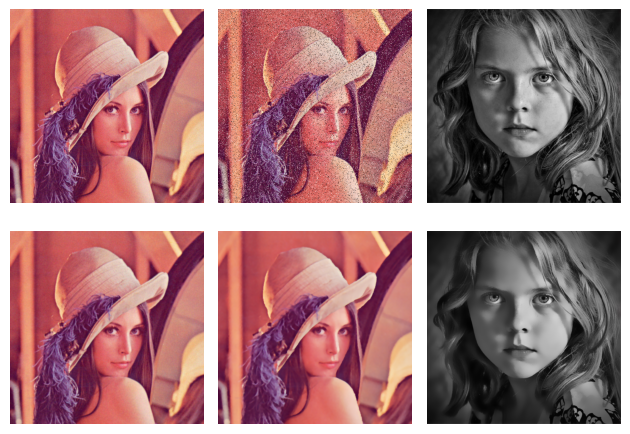

In [ ]:
ga_lena_path = 'data/gaussian_lena.png'
sp_lena_path = 'data/sp_lena.png'
bi_girl_path = 'data/bilateral.jpg'

ga_lena = np.array(imageio.imread(ga_lena_path))
sp_lena = np.array(imageio.imread(sp_lena_path))
bi_girl = np.array(imageio.imread(bi_girl_path))


filter_ga_lena = GaussianBlur(ga_lena, (3, 3), sigmaX=1.0, sigmaY=1.0)
# filter_ga_lena_rgb = cv2.cvtColor(filter_ga_lena, cv2.COLOR_BGR2RGB)
# cv2.imwrite('data/filter_ga_lena.png', filter_ga_lena_rgb)
filter_sp_lena = medianBlur(sp_lena, ksize=5)
filter_bi_girl = bilateralFilter(bi_girl, d=25, sigmaColor=40, sigmaSpace=40)
# filter_bi_girl_rgb = cv2.cvtColor(filter_bi_girl, cv2.COLOR_BGR2RGB)
# cv2.imwrite('data/filter_bi_girl1.png', filter_bi_girl_rgb)

ax = plt.subplot(231)
ax.axis('off')
ax.imshow(ga_lena)

ax = plt.subplot(232)
ax.axis('off')
ax.imshow(sp_lena)

ax = plt.subplot(233)
ax.axis('off')
ax.imshow(bi_girl)

ax = plt.subplot(234)
ax.axis('off')
ax.imshow(filter_ga_lena)

ax = plt.subplot(235)
ax.axis('off')
ax.imshow(filter_sp_lena)

ax = plt.subplot(236)
ax.axis('off')
ax.imshow(filter_bi_girl)

plt.tight_layout()
plt.show()

In [11]:
def project_and_show(model_path, fx, fy):
    '''
    Project the 3D model using perspective projection and show it in a 2D plane.
    INPUT:
    model_path: string, path of 3D model
    fx: focal length in X direction
    fy: focal length in Y direction
    
    OUTPUT:
    None
    '''

    point_cloud = o3d.io.read_point_cloud(model_path)
    points = np.asarray(point_cloud.points) # (N,3)
    ones_column = np.ones((len(points), 1))
    points_homo = np.hstack([points, ones_column]) # (N,4),hstack:splicing along the column direction

    M = np.array([
        [fx, 0, 0, 0],
        [0, fy, 0, 0],
        [0, 0, 1, 0]
        ])
    
    points_2d_homo = (M @ points_homo.T).T # (3,4)@(4,N)=(3,N)->(N,3),broadcast for @,no for-loop needed
    points_2d =  points_2d_homo[:, :2] / points_2d_homo[:, 2:3] # (fx,fy)/z

    plt.figure(figsize=(10,8))
    plt.scatter(points_2d[:, 0], points_2d[:, 1], 
                s=1,           # dot size
                alpha=0.7,     # transparency
                c='blue')      # color
    plt.gca().invert_yaxis()  # getcurrentaxis,turn the figure upside-down
    plt.xlabel('u')
    plt.ylabel('v')
    plt.title('2D Projection')
    plt.show()

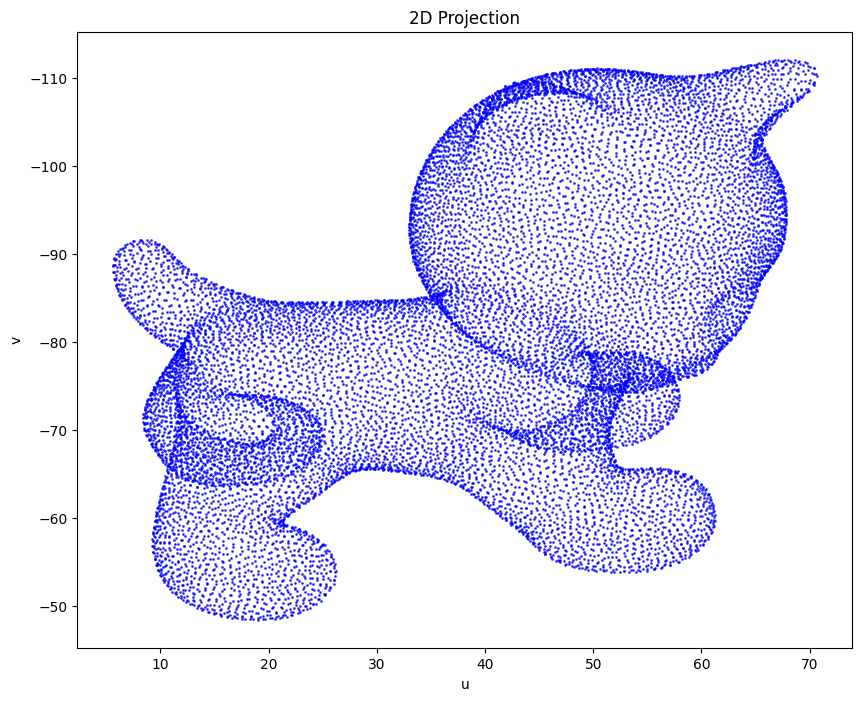

In [12]:
model_path, fx, fy = 'data/cat.ply', 572.4114, 573.57043
project_and_show(model_path, fx, fy)